In [ ]:
!pip install tensorflow[and-cuda]

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# Prevent logging Local rendezvous recv item
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import matplotlib.pyplot as plt
import math
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-08-16 04:25:33.261896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 04:25:33.278966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 04:25:33.284176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 04:25:34.280471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [ ]:
# Get project files
!rm -rf cats_and_dogs.zip* cats_and_dogs/ __MACOSX/
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [28]:
!ls cats_and_dogs/validation/

cats  dogs


In [29]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                      batch_size=batch_size,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes=["cats", "dogs"],
                                                      class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                    batch_size=batch_size,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes=["cats", "dogs"],
                                                    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(PATH,
                                                        batch_size=batch_size,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        classes=['test'],
                                                        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


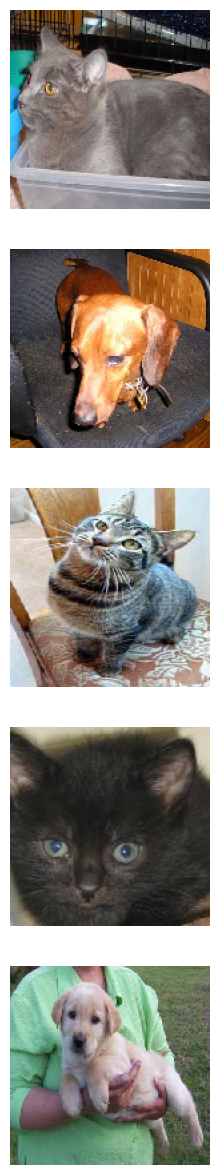

In [30]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [31]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.2,
                                            shear_range=.15,
                                            zoom_range=.2,
                                            fill_mode='nearest',
                                            horizontal_flip=True
                                           )


Found 2000 images belonging to 2 classes.


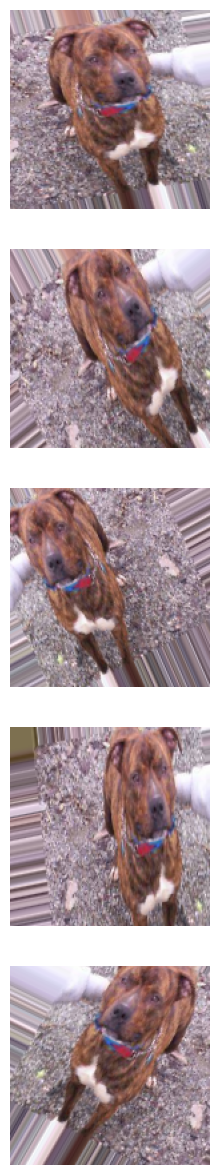

In [32]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [54]:
# 7
model = Sequential()
model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,663,873 (21.61 MB)

 Trainable params: 5,663,873 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# 8
history = None
steps_per_epoch = math.ceil(train_data_gen.samples / batch_size)
validation_steps = math.ceil(val_data_gen.samples / batch_size)

# Training the model
# Have to comment out steps params to prevent rendezvous logging ?
history = model.fit(
    train_data_gen,
    #steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    #validation_steps=validation_steps
)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 561ms/step - accuracy: 0.5269 - loss: 1.2798 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step - accuracy: 0.4882 - loss: 0.6946 - val_accuracy: 0.5480 - val_loss: 0.6919
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step - accuracy: 0.5203 - loss: 0.6923 - val_accuracy: 0.5190 - val_loss: 0.6904
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step - accuracy: 0.5092 - loss: 0.6917 - val_accuracy: 0.5170 - val_loss: 0.6898
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step - accuracy: 0.5220 - loss: 0.6896 - val_accuracy: 0.6010 - val_loss: 0.6873
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step - accuracy: 0.5539 - loss: 0.6864 - val_accuracy: 0.5290 - val_loss: 0.6827
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 561ms/step - accuracy: 0.5640 - loss: 0.6821 - val_accuracy: 0.5650 - val_loss: 0.6562
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - accuracy: 0.5805 - loss: 0.6629 - val_accu

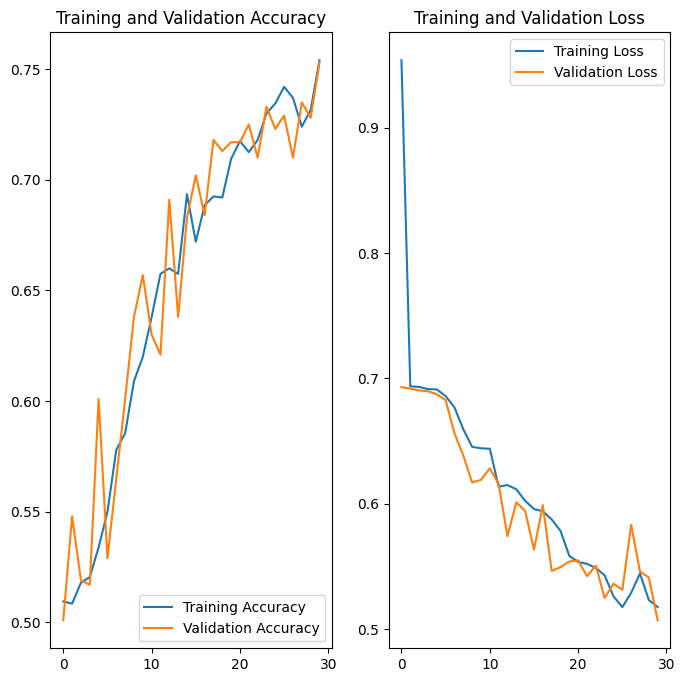

In [56]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
probabilities = model.predict(test_data_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


In [59]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 82.0% of the images of cats and dogs.
You passed the challenge!
